## TensorFlow2.0의 Keras 및 기타 라이브러리 가져오기

In [26]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow import shape
from tensorflow import math
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

print(tf.__version__)

2.0.0


![대체 텍스트](https://drive.google.com/uc?id=1OCoK4me3T3EcaEm6H-MobpVG45LrNRrh)

In [66]:
# network parameters
input_shape = 56*56
original_dim= input_shape
intermediate_dim = 512
latent_dim = 2

#hyper parametes
num_epochs = 55
batch_size = 100
learning_rate = 1e-3

## bracket 데이터 셋 로드

0


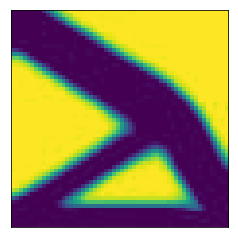

1


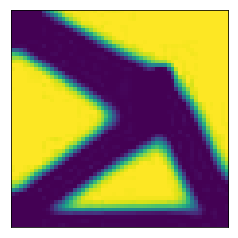

2


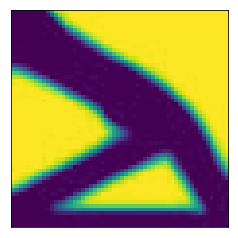

3


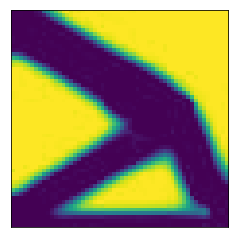

4


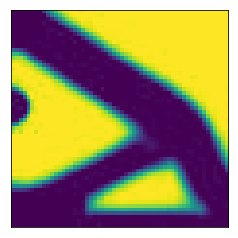

5


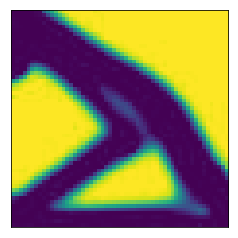

6


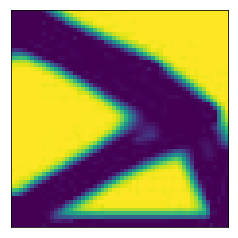

7


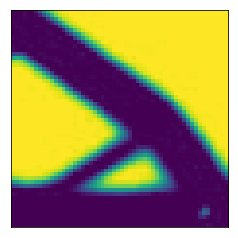

8


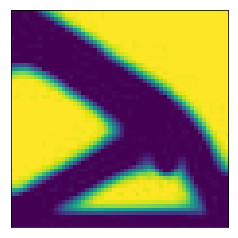

9


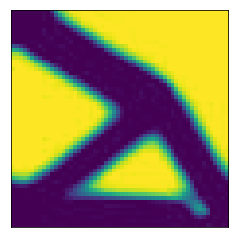

X_shape: (56, 56) Y_shape: ()
X_list shape: (7000, 56, 56) Y_list shape: (7000,)
(5600, 56, 56) (56, 56)


In [109]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_7000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장합니다. 
files = os.listdir(src)

X,Y = [],[]
count = 0

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 

for file in files:
  # 데이터의 일부분만 확인해봅니다.
  if count < 10 : 
    print(count)
    X.append(img_read_plot(src,file)/255.)
    Y.append(float(file[:-4]))
    count+=1
  else : 
    X.append(img_read(src,file)/255.)
    Y.append(float(file[:-4]))

print('X_shape:',np.shape(X[0]),'Y_shape:',np.shape(Y[0]))
print('X_list shape:',np.shape(X),'Y_list shape:',np.shape(Y))

# Train set, Test set으로 나누기 

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)
print(np.shape(x_train),np.shape(x_train[0]))

 # 28x28 이미지를 크기 784의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

# 데이터 배치를 만들고 섞어줌
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)


## VAE 모델생성
![대체 텍스트](https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg)

### (1) Encoder 생성

In [34]:
# 인코더 모델을 생성합니다.

# 인코더의 입력층을 생성합니다.
inputs = Input(shape=(input_shape,), name='input_shape')

# 인코더의 hidden층을 생성합니다. 500개의 유닛을 사용했습니다.
encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)

# 평균(mean)과 표준편차(log_sigma)층을 정의합니다. 각각 2개의 유닛을 사용했습니다.
z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(encoder_hidden)

# 평균과 표준편차를 래핑하여 Z_sampling층을만듭니다.

# Z 샘플링 함수 생성
def sampling(args):
    z_mean, z_log_var = args
    batch = shape(z_mean)[0]
    dim = shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
    epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
    return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

#  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
z_sampling = layers.Lambda(sampling, (latent_dim,), name='z')([z_mean, z_log_sigma])

# 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.   
encoder = Model(inputs,[z_mean,z_log_sigma,z_sampling], name='encoder')

# 인코더 네트워크를 확인합니다.
encoder.summary()

#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_shape (InputLayer)        [(None, 3136)]       0                                            
__________________________________________________________________________________________________
encoder_hidden1 (Dense)         (None, 512)          1606144     input_shape[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        encoder_hidden1[0][0]            
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 2)            1026        encoder_hidden1[0][0]            
____________________________________________________________________________________________

### (2) Decoder 생성

In [36]:
# 디코더의 입력층을 생성합니다. (Decoder의 입력은 latent입니다)
input_z = Input(shape=(latent_dim,), name='input_z')

# 디코더의 hidden층을 생성합니다. 인코더와 동일하게 500개의 유닛을 사용했습니다.
decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)

# 디코더의 출력층은 인코더 입력벡터 수만큼 유닛을 사용합니다.
outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

# 잠재변수 z가 입력으로 들어가고 입력 벡터만큼을 출력하는 decoder모델을 만듭니다. 
decoder = Model(input_z, outputs, name='decoder')

# 디코더의 네트워크를 확인합니다.
decoder.summary()

outputs = decoder(encoder(inputs)[0])

#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_z (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 512)               1536      
_________________________________________________________________
output (Dense)               (None, 3136)              1608768   
Total params: 1,610,304
Trainable params: 1,610,304
Non-trainable params: 0
_________________________________________________________________


### (3) VAE모델 생성

In [37]:
# build VAE model
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 3136)]            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 1608196   
_________________________________________________________________
decoder (Model)              (None, 3136)              1610304   
Total params: 3,218,500
Trainable params: 3,218,500
Non-trainable params: 0
_________________________________________________________________


In [105]:

for epoch in range(num_epochs):
    for step, x in enumerate(dataset):
        with tf.GradientTape() as tape:
            kl_div,vae_loss = loss(vae,encoder,x,original_dim)
        gradients = tape.gradient(vae_loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
        if (step + 1) % num_epochs == 0:
        
            print("Epoch[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}".format(epoch + 1, num_epochs,float(vae_loss), float(kl_div)))

Epoch[1/55], Reconst Loss: 1882.9086, KL Div: 0.3793
Epoch[2/55], Reconst Loss: 1917.1190, KL Div: 0.7633
Epoch[3/55], Reconst Loss: 1905.6379, KL Div: 0.6597
Epoch[4/55], Reconst Loss: 1916.8972, KL Div: 0.5989
Epoch[5/55], Reconst Loss: 1911.8920, KL Div: 0.4491
Epoch[6/55], Reconst Loss: 1904.1687, KL Div: 0.4516
Epoch[7/55], Reconst Loss: 1895.0143, KL Div: 0.2892
Epoch[8/55], Reconst Loss: 1880.9506, KL Div: 0.4725
Epoch[9/55], Reconst Loss: 1900.9329, KL Div: 0.2803
Epoch[10/55], Reconst Loss: 1911.7234, KL Div: 0.2989
Epoch[11/55], Reconst Loss: 1891.7267, KL Div: 0.3934
Epoch[12/55], Reconst Loss: 1919.3658, KL Div: 0.0652
Epoch[13/55], Reconst Loss: 1903.5948, KL Div: 0.4793
Epoch[14/55], Reconst Loss: 1882.5531, KL Div: 0.4905
Epoch[15/55], Reconst Loss: 1878.4774, KL Div: 0.4606
Epoch[16/55], Reconst Loss: 1926.0303, KL Div: 0.5782
Epoch[17/55], Reconst Loss: 1887.8776, KL Div: 0.2787
Epoch[18/55], Reconst Loss: 1909.2483, KL Div: 0.8669
Epoch[19/55], Reconst Loss: 1909.1732

## 원본이미지와 복원이미지 비교

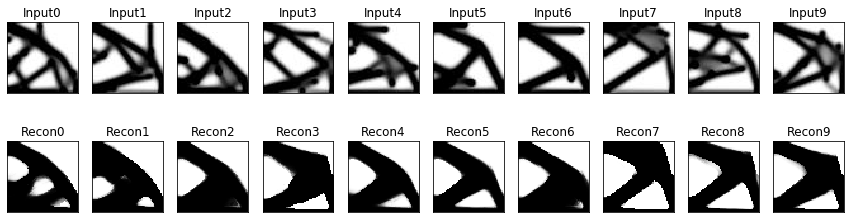

In [106]:
recon_x_test = vae.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()

## 2D공간에 잠재된 데이터 출력

In [107]:
# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digitsa
    n = 30
    digit_size = 56
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

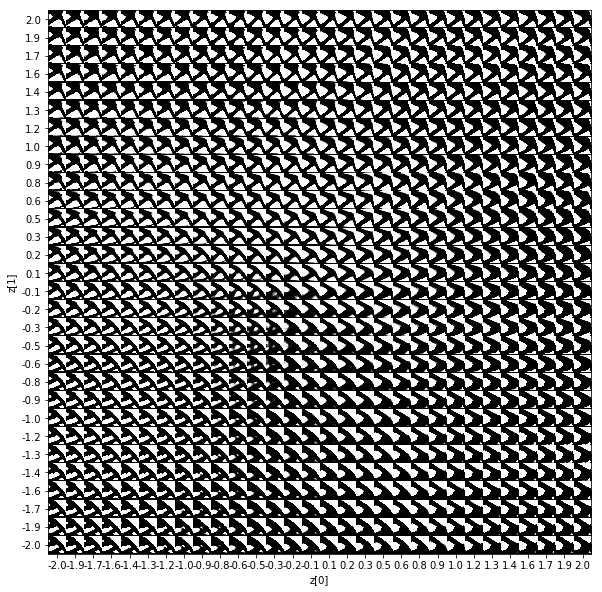

In [83]:
plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

## 데이터 간 Interpolation

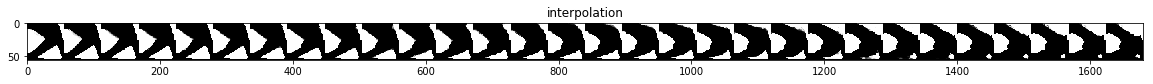

In [108]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 56
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

canvas = np.empty((56, 56*n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_hat = decoder.predict(z_sample)
        canvas[:, i*56: (i+1)*56] = x_hat[0].reshape(56, 56)
fig, ax = plt.subplots(figsize=(20,20))             
plt.title("interpolation")
ax.imshow(canvas, cmap="gray")